In [1]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
# Read in the training data set
df = pd.read_csv('train.csv', sep=',',keep_default_na=False, na_values='null')
# Display shape of the data
print(df.shape)
print(df)

(13288920, 13)
                id           valid_time  latitude  longitude            tp  \
0                1  2018-01-01 00:00:00      59.0      -8.00  3.814697e-06   
1                2  2018-01-01 00:00:00      59.0      -7.75  1.668930e-05   
2                3  2018-01-01 00:00:00      59.0      -7.50  1.811981e-05   
3                4  2018-01-01 00:00:00      59.0      -7.25  1.907349e-05   
4                5  2018-01-01 00:00:00      59.0      -7.00  1.525879e-05   
...            ...                  ...       ...        ...           ...   
13288915  13288916  2018-12-31 23:00:00      50.0       1.00  1.239777e-05   
13288916  13288917  2018-12-31 23:00:00      50.0       1.25  1.621246e-05   
13288917  13288918  2018-12-31 23:00:00      50.0       1.50  3.814697e-06   
13288918  13288919  2018-12-31 23:00:00      50.0       1.75  1.907349e-06   
13288919  13288920  2018-12-31 23:00:00      50.0       2.00  9.536743e-07   

               u10       v10          sp      u1

In [4]:
X_train = df.drop(columns=['t2m'])  # Features
y_train = df['t2m']  # Labels (y will be a temperature in K)

# Data Exploration

In [5]:
explore_df = df.copy(deep=True)

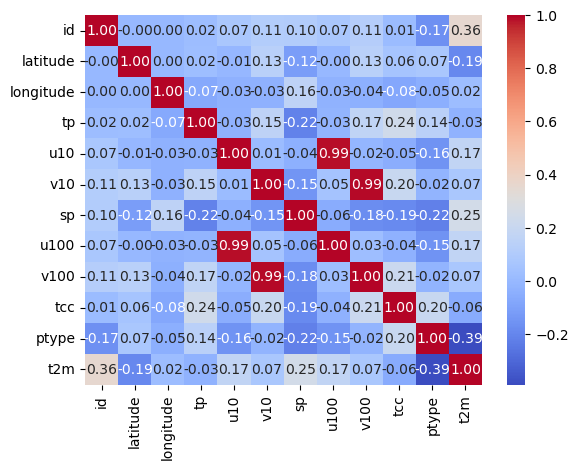

In [6]:
corr_matrix = df.drop("valid_time", axis=1).corr()

# Plot heatmap
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")

# Show the plot
plt.show()

In [7]:
# Finding attribute characteristics:
def analyze_dataframe(explore_df):
    results = []
    for col in explore_df.columns:
        col_data = explore_df[col]
        dtype = col_data.dtype
        # Get percentage of missing data
        missing = (len(explore_df[explore_df[col] == "unknown"]) / len(explore_df)) * 100
        # Determine the noisiness of results (if there are outliers) (only for numerical)
        if np.issubdtype(dtype, np.number):
            # Find z-score (how far a data point is from the mean)
            z_scores = np.abs(stats.zscore(col_data)) if len(col_data) > 1 else np.array([])
            outliers = np.sum(z_scores > 3)  # Count outliers, we define as z score of more than 3
            noise_type = []
            if outliers > 0:
                # If there are outliers,
                noise_desc = "Outliers"
            else:
                noise_desc = "None"
        else:
            noise_desc = "None"
        # Determining the type of distribution (only for numerical)
        if np.issubdtype(dtype, np.number) and len(col_data) > 1:
            skewness = stats.skew(col_data)
            if np.all(col_data >= 0) and skewness > 1:
                distribution = "Log-normal"
            elif -0.5 < skewness < 0.5:
                distribution = "Gaussian"
            else:
                distribution = "Other"
        else:
            distribution = "Categorical" if explore_df[col].dtype == 'object' else "Uniform"

        results.append([col, str(dtype), f"{missing:.2f}%", noise_desc, distribution])
    return pd.DataFrame(results, columns=["Name", "Type", "% Missing", "Noisiness", "Distribution"])


analyze_dataframe(explore_df)

NameError: name 'stats' is not defined

## Checking for any duplciated observations  

If the number of duplicated observations is greater than 0, then further code can be created to remove these duplciated from the dataset.

In [8]:
# Check for duplicates
duplicate_rows = explore_df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_rows}")

Number of duplicate rows: 0


In [9]:
# I shall attempt to divide the datasets into times:
explore_df['valid_time'] = pd.to_datetime(explore_df['valid_time'])

display(explore_df)
explore_df_jan = explore_df.loc[explore_df['valid_time'] < '2018-02-01 00:00:00']
remainder = explore_df.loc[explore_df['valid_time'] >= '2018-02-01 00:00:00']

explore_df_feb = remainder.loc[remainder['valid_time'] < '2018-03-01 00:00:00']
remainder = explore_df.loc[explore_df['valid_time'] >= '2018-03-01 00:00:00']

explore_df_mar = remainder.loc[remainder['valid_time'] < '2018-04-01 00:00:00']
remainder = explore_df.loc[explore_df['valid_time'] >= '2018-04-01 00:00:00']

explore_df_apr = remainder.loc[remainder['valid_time'] < '2018-05-01 00:00:00']
remainder = explore_df.loc[explore_df['valid_time'] >= '2018-05-01 00:00:00']

explore_df_may = remainder.loc[remainder['valid_time'] < '2018-06-01 00:00:00']
remainder = explore_df.loc[explore_df['valid_time'] >= '2018-06-01 00:00:00']

explore_df_jun = remainder.loc[remainder['valid_time'] < '2018-07-01 00:00:00']
remainder = explore_df.loc[explore_df['valid_time'] >= '2018-07-01 00:00:00']

explore_df_jul = remainder.loc[remainder['valid_time'] < '2018-08-01 00:00:00']
remainder = explore_df.loc[explore_df['valid_time'] >= '2018-08-01 00:00:00']

explore_df_aug = remainder.loc[remainder['valid_time'] < '2018-09-01 00:00:00']
remainder = explore_df.loc[explore_df['valid_time'] >= '2018-09-01 00:00:00']

explore_df_sep = remainder.loc[remainder['valid_time'] < '2018-10-01 00:00:00']
remainder = explore_df.loc[explore_df['valid_time'] >= '2018-10-01 00:00:00']

explore_df_oct = remainder.loc[remainder['valid_time'] < '2018-11-01 00:00:00']
remainder = explore_df.loc[explore_df['valid_time'] >= '2018-11-01 00:00:00']

explore_df_nov = remainder.loc[remainder['valid_time'] < '2018-12-01 00:00:00']
remainder = explore_df.loc[explore_df['valid_time'] >= '2018-12-01 00:00:00']

explore_df_dec = remainder.loc[remainder['valid_time'] <= '2018-12-31 00:00:00']


id          valid_time  latitude  longitude            tp  \
0                1 2018-01-01 00:00:00      59.0      -8.00  3.814697e-06   
1                2 2018-01-01 00:00:00      59.0      -7.75  1.668930e-05   
2                3 2018-01-01 00:00:00      59.0      -7.50  1.811981e-05   
3                4 2018-01-01 00:00:00      59.0      -7.25  1.907349e-05   
4                5 2018-01-01 00:00:00      59.0      -7.00  1.525879e-05   
...            ...                 ...       ...        ...           ...   
13288915  13288916 2018-12-31 23:00:00      50.0       1.00  1.239777e-05   
13288916  13288917 2018-12-31 23:00:00      50.0       1.25  1.621246e-05   
13288917  13288918 2018-12-31 23:00:00      50.0       1.50  3.814697e-06   
13288918  13288919 2018-12-31 23:00:00      50.0       1.75  1.907349e-06   
13288919  13288920 2018-12-31 23:00:00      50.0       2.00  9.536743e-07   

               u10       v10          sp      u100      v100       tcc  ptype  \
0         1.405868 -1.367767   98134.810  1.516388 -1.468002  0.968842    1.0   
1         2.151962 -1.555267   98086.810  2.239044 -1.634994  0.978790    1.0   
2         2.691025 -1.585541   98078.810  2.783966 -1.686752  0.975586    1.0   
3         2.850204 -1.714447   98076.810  2.971466 -1.854721  0.978790    1.0   
4         3.299423 -1.867767   98084.810  3.455841 -2.001205  0.968842    1.0   
...            ...       ...         ...       ...       ...       ...    ...   
13288915  2.973770 -0.559326  102930.375  4.842743 -1.398544  0.967163    1.0   
13288916  2.772598 -0.156982  102743.375  4.761688 -0.968857  0.991669    1.0   
13288917  2.175919  0.240479  102498.375  4.639618 -0.573349  0.996307    1.0   
13288918  2.238419  0.259033  102425.375  4.661102 -0.463974  0.978363    1.0   
13288919  2.154434  0.307861  102450.375  4.565399 -0.359482  0.959137    1.0   

                t2m  
0         279.75903  
1         279.61255  
2         279.71997  
3         279.78247  
4         279.86646  
...             ...  
13288915  282.03857  
13288916  281.70264  
13288917  281.20654  
13288918  281.01123  
13288919  280.85693  

[13288920 rows x 13 columns]

37


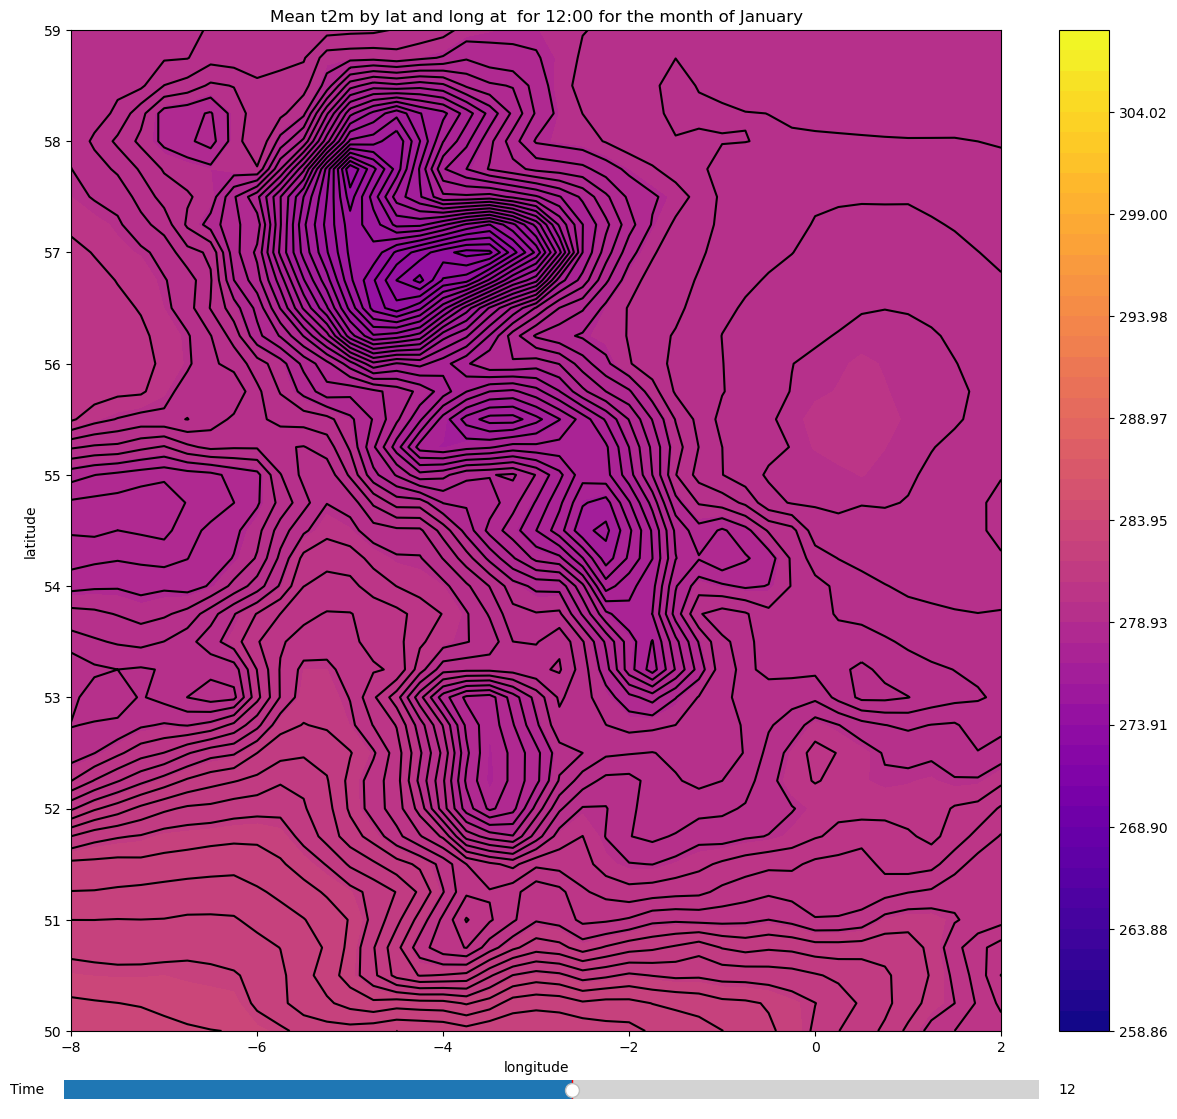

In [10]:
from matplotlib.widgets import Slider

temp_scale = np.linspace(explore_df["t2m"].min(), explore_df["t2m"].max(), 50)


def exploration_pipeline( full_data, month, hour_val, interest = "t2m", feat_scale = temp_scale):
    train_data_full = full_data.copy()

    max_heatbar = train_data_full["t2m"].max()
    min_heatbar = train_data_full["t2m"].min()

    def average_loc_feature(interest, hour_wanted):  #hour Interger between 0 and 23, interest is the name of the feature of interest
        lat_values = train_data_full["latitude"].unique()
        long_values = train_data_full["longitude"].unique()
        #long_values = long_values[:len(lat_values)]
        mean_feat_vals = np.zeros([len(lat_values), len(long_values)])
        #for lat_val in lat_values:
        for i in range(len(long_values)):
            #for long_val in long_values:
            for j in range(len(lat_values)):
                #print(long_values[i], lat_values[j])

                refined_data = train_data_full.loc[train_data_full['latitude'] == lat_values[j]]
                refined_data_2 = refined_data.loc[refined_data['longitude'] == long_values[i]]
                refined_data_2["valid_time"] = pd.to_datetime(refined_data_2["valid_time"])
                refined_data_2["hour_value"] = refined_data_2["valid_time"].dt.hour
                refined_data_3 = refined_data_2.loc[refined_data_2["hour_value"] == hour_wanted]

                mean_feature = refined_data_3[interest].mean()

                mean_feat_vals[j][i] = mean_feature

        print(len(mean_feat_vals))

        return mean_feat_vals, lat_values, long_values

    mean_feat_vals, lat_values, long_values = average_loc_feature(interest, hour_val)

    longx, laty = np.meshgrid(long_values, lat_values)
    fig, ax1 = plt.subplots(figsize=(15, 13))

    level_lines = np.arange(min_heatbar, max_heatbar + 0.5, 0.25)
    #levels = np.arange(min_heatbar, max_heatbar + 0.2, 0.1)
    levels = feat_scale
    hour_wanted = 0

    contours = ax1.contour(longx, laty, mean_feat_vals, levels=level_lines, colors = "k")
    heatmap = ax1.contourf(longx, laty, mean_feat_vals, levels=levels, cmap = "plasma")
    ax1.set_xlabel("longitude")
    ax1.set_ylabel("latitude")
    if len(str(hour_val)) == 2:
        ax1.set_title("Mean " + interest + " by lat and long at  for " + str(hour_val) + ":00 for the month of " + month)
    else:
        ax1.set_title("Mean " + interest + " by lat and long at  for 0" + str(hour_val) + ":00 for the month of " + month)



    ax_slide = fig.add_axes([0.12, 0.05, 0.65, 0.03])     #properties of slider
    time_silder = Slider(ax_slide, label="Time", valmin= 0, valmax = 23, valinit= hour_val, valstep= 1)

    def updated_graph(val):
        ax1.cla()
        new_time = time_silder.val
        mean_feat_vals_slider, lat_values_slider, long_values_slider = average_loc_feature("t2m", new_time)
        longx, laty = np.meshgrid(long_values_slider, lat_values_slider)
        level_lines = np.arange(np.min(mean_feat_vals_slider), np.max(mean_feat_vals_slider) + 1, 0.25)
        #levels = np.arange(np.min(mean_feat_vals_slider), np.max(mean_feat_vals_slider) + 1, 0.1)
        levels = feat_scale
        contours_slider = ax1.contour(longx, laty, mean_feat_vals_slider, levels=level_lines, colors = "k")
        heatmap_slider = ax1.contourf(longx, laty, mean_feat_vals_slider, levels=levels, cmap = "plasma")
        if len(str(hour_val)) == 2:
            ax1.set_title("Mean " + interest + " by lat and long at  for " + str(new_time) + ":00 for the month of " + month)
        else:
            ax1.set_title("Mean " + interest + " by lat and long at  for 0" + str(new_time) + ":00 for the month of " + month)
        return heatmap_slider

    time_silder.on_changed(updated_graph)
    fig.colorbar(heatmap, ax=ax1)

    return time_silder

# jan_training_1, jan_training_2, jan_training_3, jan_training_4, jan_training_5, jan_labels_1, jan_labels_2, jan_labels_3, jan_labels_4, jan_labels_5 = sampling_data(df_train_2_jan, 0.01)
jan_slider = exploration_pipeline(explore_df_jan, "January", 12, "t2m")


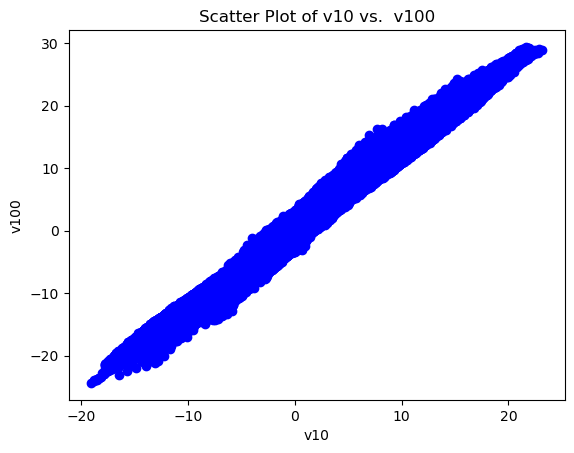

In [11]:
plt.scatter(explore_df['v10'], explore_df['v100'], color='blue', marker='o')
plt.xlabel('v10')
plt.ylabel('v100')
plt.title('Scatter Plot of v10 vs.  v100')
plt.show()

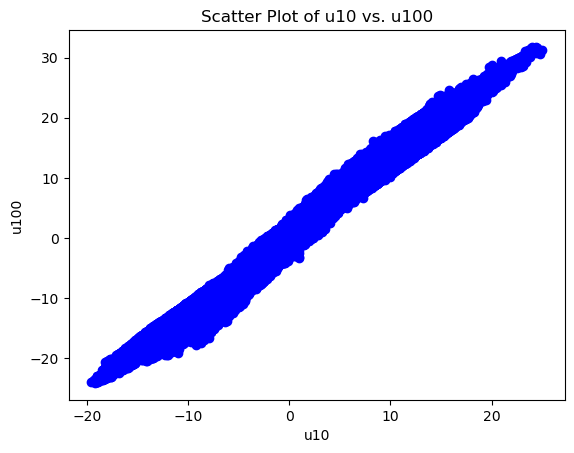

In [12]:
plt.scatter(explore_df['u10'], explore_df['u100'], color='blue', marker='o')
plt.xlabel('u10')
plt.ylabel('u100')
plt.title('Scatter Plot of u10 vs. u100')
plt.show()

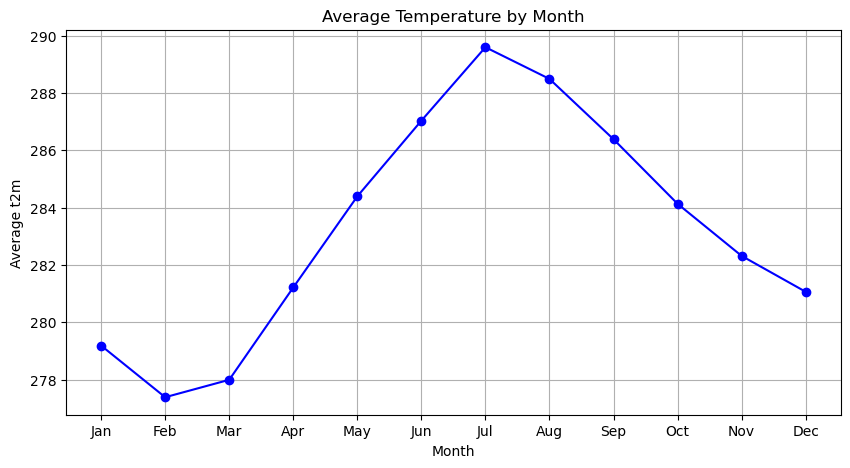

In [13]:
# Convert 'valid_time' to datetime format
explore_df['valid_time'] = pd.to_datetime(explore_df['valid_time'])

# Extract month and calculate the average t2m
explore_df['month'] = explore_df['valid_time'].dt.month
monthly_avg_temp = explore_df.groupby('month')['t2m'].mean()

# Plot the monthly average t2m
plt.figure(figsize=(10, 5))
plt.plot(monthly_avg_temp.index, monthly_avg_temp.values, marker='o', linestyle='-', color='b')
plt.xlabel('Month')
plt.ylabel('Average t2m')
plt.title('Average Temperature by Month')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid()
plt.show()

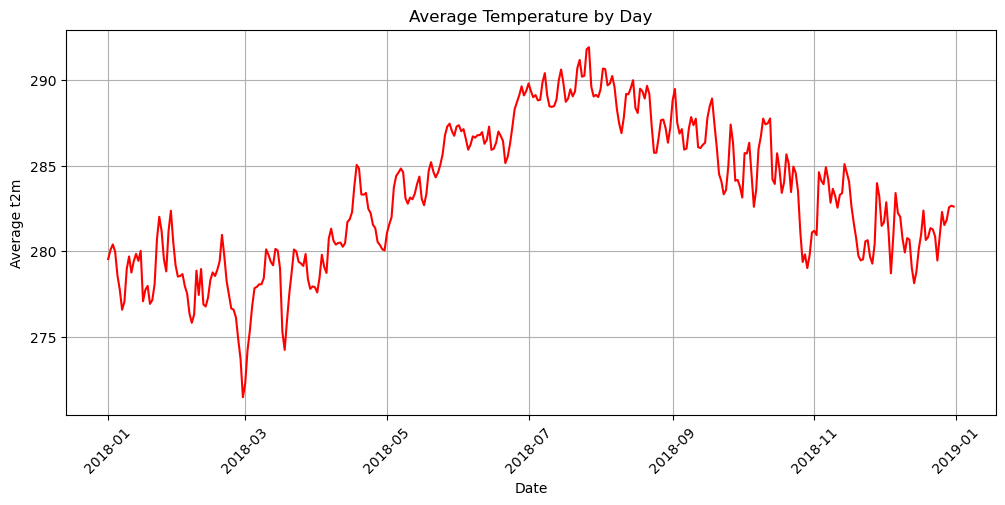

In [14]:
explore_df['date'] = explore_df['valid_time'].dt.date
daily_avg_temp = explore_df.groupby('date')['t2m'].mean()
plt.figure(figsize=(12, 5))
plt.plot(daily_avg_temp.index, daily_avg_temp.values, color='r')
plt.xlabel('Date')
plt.ylabel('Average t2m')
plt.title('Average Temperature by Day')
plt.xticks(rotation=45)
plt.grid()
plt.show()

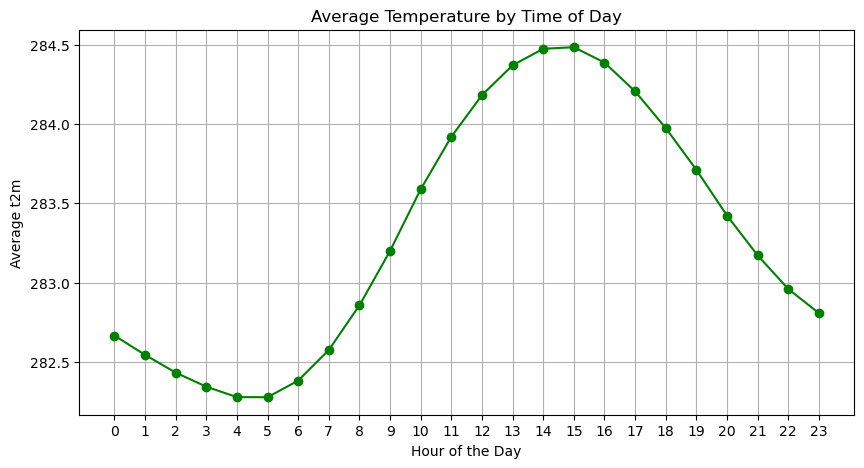

In [15]:
explore_df['valid_time'] = pd.to_datetime(explore_df['valid_time'])
explore_df['hour'] = explore_df['valid_time'].dt.hour
hourly_avg_temp = explore_df.groupby('hour')['t2m'].mean()
plt.figure(figsize=(10, 5))
plt.plot(hourly_avg_temp.index, hourly_avg_temp.values, marker='o', linestyle='-', color='g')
plt.xlabel('Hour of the Day')
plt.ylabel('Average t2m')
plt.title('Average Temperature by Time of Day')
plt.xticks(range(0, 24))  # Show every hour on x-axis
plt.grid()
plt.show()

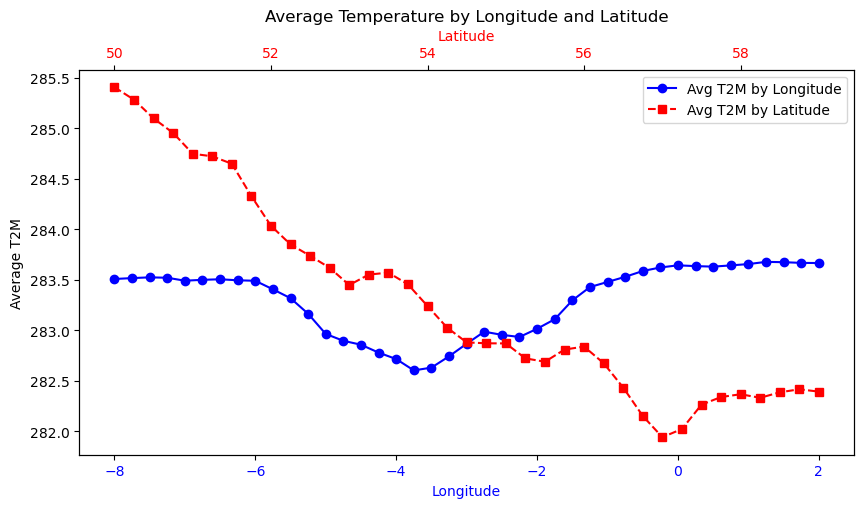

In [16]:
# Group by longitude/latitude
avg_temps_by_longitude = explore_df.groupby('longitude')['t2m'].mean().reset_index()
avg_temps_by_latitude = explore_df.groupby('latitude')['t2m'].mean().reset_index()
avg_temps_by_longitude = avg_temps_by_longitude.sort_values(by='longitude')
avg_temps_by_latitude = avg_temps_by_latitude.sort_values(by='latitude')

fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.plot(avg_temps_by_longitude['longitude'], avg_temps_by_longitude['t2m'], marker='o', linestyle='-', color='blue', label='Avg T2M by Longitude')
ax1.set_xlabel('Longitude', color='blue')
ax1.tick_params(axis='x', labelcolor='blue')

# Secondary Axis
ax2 = ax1.twiny()
ax2.plot(avg_temps_by_latitude['latitude'], avg_temps_by_latitude['t2m'], marker='s', linestyle='--', color='red', label='Avg T2M by Latitude')
ax2.set_xlabel('Latitude', color='red')
ax2.tick_params(axis='x', labelcolor='red')

# Labels/Legends
ax1.set_ylabel('Average T2M')
ax1.set_title('Average Temperature by Longitude and Latitude')
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.show()

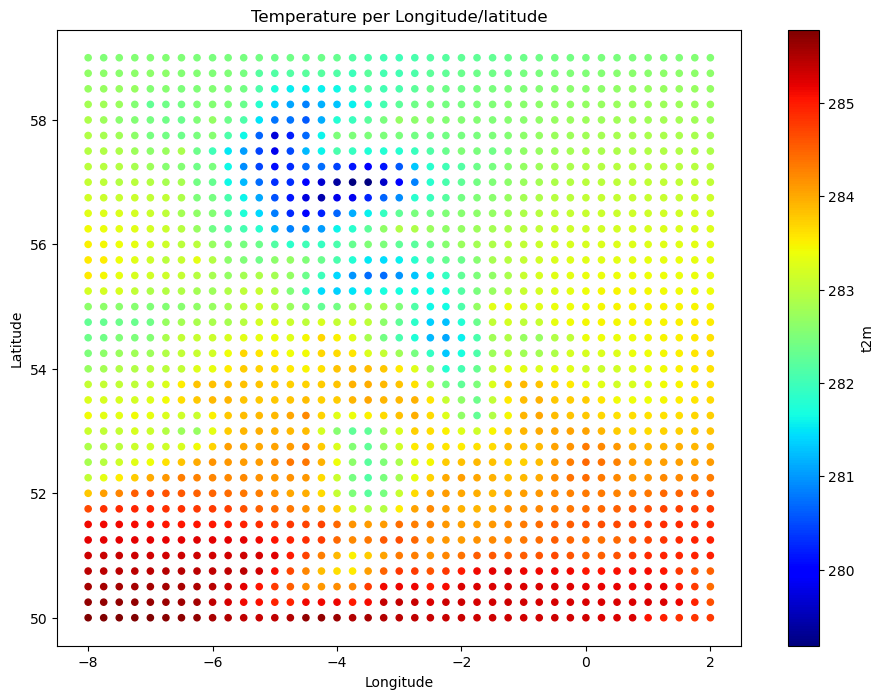

In [17]:
df_max = explore_df.groupby(['longitude', 'latitude'], as_index=False)['t2m'].mean()

# Scatter plot using longitude and latitude as coordinates
map = df_max.plot.scatter(
    x='longitude',
    y='latitude',
    c='t2m',
    cmap='jet',
    colorbar=True,
    figsize=(12, 8),
)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Temperature per Longitude/latitude")
map.set_aspect('equal')
plt.show()

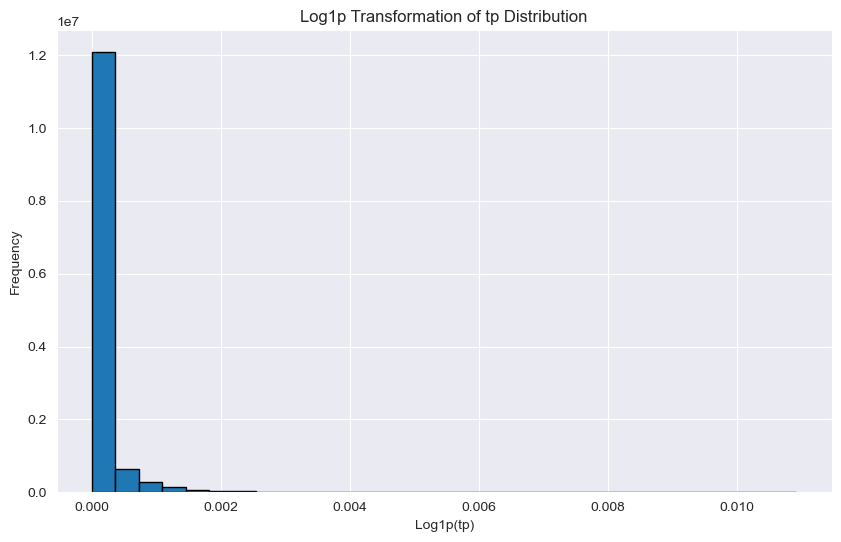

In [18]:
# Plot the histogram of the log1p-transformed 'ptype' (without modifying the original 'ptype' column)
plt.figure(figsize=(10, 6))
plt.hist(np.log1p(df['tp']), bins=30, edgecolor='black')  # Apply log1p for visualization
plt.title('Log1p Transformation of tp Distribution')
plt.xlabel('Log1p(tp)')
plt.ylabel('Frequency')
plt.show()

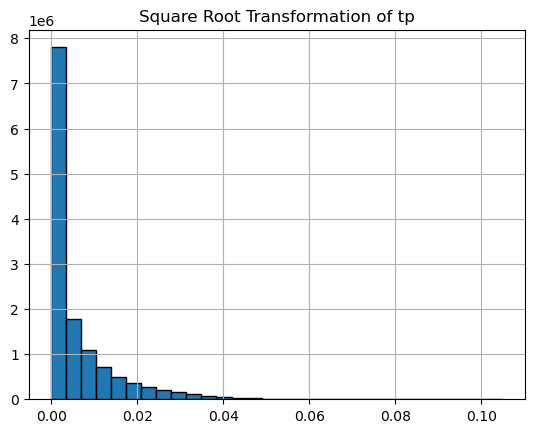

In [18]:
df['tp_sqrt'] = np.sqrt(df['tp'])
df['tp_sqrt'].hist(bins=30, edgecolor='black')
plt.title('Square Root Transformation of tp')
plt.show()

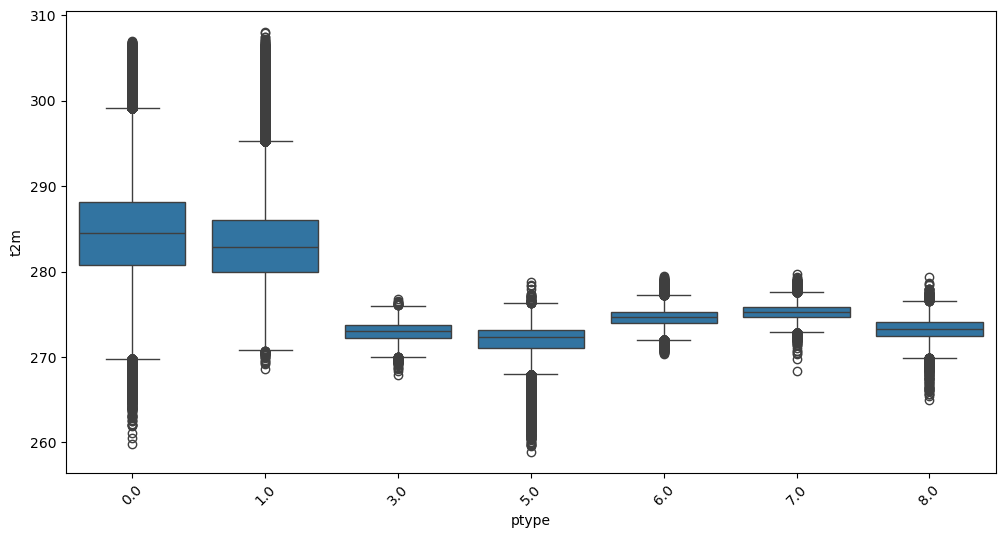

In [19]:
# Visualise relationships between variables and response:
plt.figure(figsize=(12, 6))
sns.boxplot(x='ptype', y='t2m', data=df)
plt.xticks(rotation=45)

# Show the plot
plt.show()

In [20]:
import statsmodels.formula.api as smf

df_sample_explore = explore_df.sample(n = 100000, random_state=99)

# Drop id and valid_time
df_model = df_sample_explore.drop(columns=['id', 'valid_time', 'u100', 'v100'])

# Define the formula with interactions
# This uses * to include both main effects and interactions
# You can also use specific terms like: tp + u10 + v10 + sp + ... + ptype + tp:ptype + ...

formula = 't2m ~ (u10 + v10 + sp + tcc + tp) ** 2'

# Fit the linear regression model
model = smf.ols(formula=formula, data=df_model).fit()

# View the summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    t2m   R-squared:                       0.135
Model:                            OLS   Adj. R-squared:                  0.135
Method:                 Least Squares   F-statistic:                     1043.
Date:                Wed, 23 Apr 2025   Prob (F-statistic):               0.00
Time:                        17:23:22   Log-Likelihood:            -2.9373e+05
No. Observations:              100000   AIC:                         5.875e+05
Df Residuals:                   99984   BIC:                         5.877e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    211.1864      2.483     85.036      0.0

In [21]:
explore_df_2 = df_model.copy(deep=True)
explore_df_2['u10_x_tcc'] = explore_df_2['u10']*explore_df_2['tcc']
explore_df_2['u10_x_tp'] = explore_df_2['u10']*explore_df_2['tp']
explore_df_2['v10_x_tcc'] = explore_df_2['v10']*explore_df_2['tcc']
explore_df_2['v10_x_tp'] = explore_df_2['v10']*explore_df_2['tp']
explore_df_2['tcc_x_tp'] = explore_df_2['tcc']*explore_df_2['tp']

explore_df_2

latitude  longitude            tp       u10       v10          sp  \
8627368      58.00      -1.75  0.000000e+00  1.417801 -0.279449  101223.440   
13034925     53.75      -8.00  4.768372e-07 -1.789627  2.627884  102025.810   
8314463      51.25       0.00  0.000000e+00  2.038422 -0.116867  100921.250   
3654882      56.50      -3.25  4.768372e-07 -4.326843 -1.898514   99676.125   
8356647      53.00      -1.25  0.000000e+00  5.397247  3.035675  100830.060   
...            ...        ...           ...       ...       ...         ...   
876310       53.00      -3.75  3.290176e-04  3.764206  4.809998   96475.940   
4522373      58.00       0.00  0.000000e+00  2.804550  6.558151  102076.000   
1943932      55.25       2.00  1.430511e-06 -3.559860  2.458054  102663.250   
9053911      56.25      -7.00  5.149841e-05  3.018036 -6.592239  101732.875   
10388598     58.00      -3.50  0.000000e+00  1.881653  4.089401   99896.250   

               tcc  ptype        t2m  month        date  hour  u10_x_tcc  \
8627368   0.996185    0.0  284.68896      8  2018-08-25    23   1.412392   
13034925  0.881195    1.0  282.06006     12  2018-12-25     0  -1.577011   
8314463   0.927277    0.0  288.39514      8  2018-08-17     8   1.890181   
3654882   0.983490    0.0  279.49340      4  2018-04-11     9  -4.255407   
8356647   0.995453    0.0  294.65990      8  2018-08-18    12   5.372705   
...            ...    ...        ...    ...         ...   ...        ...   
876310    0.886536    1.0  278.33813      1  2018-01-25     1   3.337103   
4522373   0.737854    1.0  281.88806      5  2018-05-05     5   2.069349   
1943932   0.962952    0.0  277.46924      2  2018-02-23     9  -3.427973   
9053911   0.339111    1.0  285.34033      9  2018-09-06    16   1.023450   
10388598  1.000000    0.0  284.74220     10  2018-10-13     8   1.881653   

              u10_x_tp  v10_x_tcc      v10_x_tp      tcc_x_tp  
8627368   0.000000e+00  -0.278383 -0.000000e+00  0.000000e+00  
13034925 -8.533607e-07   2.315678  1.253073e-06  4.201866e-07  
8314463   0.000000e+00  -0.108368 -0.000000e+00  0.000000e+00  
3654882  -2.063200e-06  -1.867169 -9.052819e-07  4.689646e-07  
8356647   0.000000e+00   3.021871  0.000000e+00  0.000000e+00  
...                ...        ...           ...           ...  
876310    1.238490e-03   4.264234  1.582574e-03  2.916859e-04  
4522373   0.000000e+00   4.838958  0.000000e+00  0.000000e+00  
1943932  -5.092421e-06   2.366987  3.516274e-06  1.377513e-06  
9053911   1.554241e-04  -2.235503 -3.394899e-04  1.746370e-05  
10388598  0.000000e+00   4.089401  0.000000e+00  0.000000e+00  

[100000 rows x 17 columns]

In [22]:
# Initialise the Decision Tree Regressor
dt_regressor_sqtp2 = DecisionTreeRegressor(max_depth=5, random_state=42)
y_label_sample = y_train.loc[explore_df_2.index]
explore_df_2 = explore_df_2.drop(columns='t2m')

# Fit the model to training data
dt_regressor_sqtp2.fit(explore_df_2, y_label_sample)

# Feature Importance
feature_importance = pd.DataFrame({
    'Feature': explore_df_2.columns,
    'Importance': dt_regressor_sqtp2.feature_importances_
}).sort_values(by="Importance", ascending=False)

print(feature_importance)

TypeError: float() argument must be a string or a real number, not 'datetime.date'

In [23]:
original_feat_headers = df.columns.values
# Make histogram of each feature
# for feat in original_feat_headers:
#     df[feat].hist()

In [24]:
def daily_temps(data, labels, full_data, month, hour_val):

    train_data = data.copy()
    train_data_full = full_data.copy()

    #Now lets look at some temporal analysis:

    def time_loc_temps(lower = 0, upper = -1):
        lat_values = train_data_full["latitude"].unique()
        long_values = train_data_full["longitude"].unique()
        for lat_val in lat_values[lower:upper]:
            for long_val in long_values[lower:upper]:
        
                refined_data = train_data_full.loc[train_data_full['latitude'] == lat_val]
                refined_data_2 = refined_data.loc[refined_data['longitude'] == long_val]

                time_ints = refined_data_2["valid_time"]
                fig, ax4 = plt.subplots(figsize=(15, 13))
                ax4.plot(time_ints, refined_data_2["t2m"])
                ax4.set_xlabel("Date and Time")
                ax4.set_ylabel("Temperature")
                ax4.set_title("Temperatures recorded over the course of month " + month)

        return
    
    def average_loc_feature(interest, hour_wanted):  #hour Interger between 0 and 23, interest is the name of the feature of interest
        lat_values = train_data_full["latitude"].unique()
        long_values = train_data_full["longitude"].unique()
        #long_values = long_values[:len(lat_values)]
        mean_feat_vals = np.zeros([len(lat_values), len(long_values)])
        #for lat_val in lat_values:
        for i in range(len(long_values)):
            #for long_val in long_values:
            for j in range(len(lat_values)):
                #print(long_values[i], lat_values[j])
        
                refined_data = train_data_full.loc[train_data_full['latitude'] == lat_values[j]]
                refined_data_2 = refined_data.loc[refined_data['longitude'] == long_values[i]]
                refined_data_2["valid_time"] = pd.to_datetime(refined_data_2["valid_time"])
                refined_data_2["hour_value"] = refined_data_2["valid_time"].dt.hour
                refined_data_3 = refined_data_2.loc[refined_data_2["hour_value"] == hour_wanted]

                mean_feature = refined_data_3[interest].mean()
                
                mean_feat_vals[j][i] = mean_feature

        longx, laty = np.meshgrid(long_values, lat_values)

        fig, ax1 = plt.subplots(figsize=(15, 13))

        levels = np.arange(np.min(mean_feat_vals), np.max(mean_feat_vals) + 1, 0.25)

        contours = ax1.contour(longx, laty, mean_feat_vals, levels=levels, colors = "k")
        heatmap = ax1.contourf(longx, laty, mean_feat_vals, levels=levels, cmap = "plasma")
        #cntr1 = ax1.tricontourf(lat_values, long_values, mean_feat_vals, cmap = "plasma")
        ax1.set_xlabel("longitude")
        ax1.set_ylabel("latitude")
        if len(str(hour_wanted)) == 2:
            ax1.set_title("Mean " + interest + " by lat and long at  for " + str(hour_wanted) + ":00 for the month of " + month)
        else:
            ax1.set_title("Mean " + interest + " by lat and long at  for 0" + str(hour_wanted) + ":00 for the month of " + month)
        fig.colorbar(heatmap, ax=ax1)

        print("Run Complete")

        
        return
    
    def average_temp_day(interest):  #hour Interger between 0 and 23, interest is the name of the feature of interest
        lat_values = train_data_full["latitude"].unique()
        long_values = train_data_full["longitude"].unique()
        #long_values = long_values[:len(lat_values)]
        
        all_day_means = []
        
        #for lat_val in lat_values:
        for i in range(len(long_values)):
            #for long_val in long_values:
            for j in range(len(lat_values)):
                #print(long_values[i], lat_values[j])
                day_array = []
                mean_feat_vals = []
        
                refined_data = train_data_full.loc[train_data_full['latitude'] == lat_values[j]]
                refined_data_2 = refined_data.loc[refined_data['longitude'] == long_values[i]]
                refined_data_2["valid_time"] = pd.to_datetime(refined_data_2["valid_time"])
                refined_data_2["day_value"] = refined_data_2["valid_time"].dt.day
                last_day = refined_data_2["day_value"].max()
                for day_val in range(1, last_day+1):
                    refined_data_3 = refined_data_2.loc[refined_data_2["day_value"] == day_val]

                    mean_feature = refined_data_3[interest].mean()
                
                    mean_feat_vals.append(mean_feature)
                    day_array.append(day_val)
                
                all_day_means.append(mean_feat_vals)
       

        fig, ax5 = plt.subplots(figsize=(15, 13))
        
        daily_average = np.zeros(len(day_array))

        for vals in all_day_means:
            ax5.plot(day_array, vals)
            
        ax5.set_xlabel("Day of the Month")
        ax5.set_ylabel("Average Temperature by location")
        ax5.set_title("Mean " + interest + " by day for lat and long the month of " + month)
        
        fig, ax6 = plt.subplots(figsize=(15, 13))
        for day in day_array:
            daily_mean_temp_total = 0
            for i in range(len(all_day_means)):
                daily_mean_temp_total += all_day_means[i][day-1]
            daily_average[day-1] = daily_mean_temp_total/len(all_day_means)
            
        ax6.plot(day_array, daily_average)
        ax6.set_xlabel("Day of the Month")
        ax6.set_ylabel("Average Temperature country-wide")
        ax6.set_title("Mean " + interest + " by day for the month of " + month)

        print("Run Complete")

        
        return daily_average
    
    time_loc_temps(10, 11)
    average_loc_feature("t2m", hour_val)
    #average_loc_feature("u10", hour_val)
    #average_loc_feature("u100", hour_val)
    #average_loc_feature("v10", hour_val)
    #average_loc_feature("v100", hour_val)
    
    mon_daily_average = average_temp_day("t2m")
    
    return mon_daily_average


Run Complete
Run Complete


array([279.52860422, 280.06661219, 280.38666402, 279.96155529,
       278.56499912, 277.73496726, 276.56582599, 277.03700666,
       278.9605572 , 279.68243155, 278.73889532, 279.39665692,
       279.83354406, 279.42499342, 280.00796672, 277.05909777,
       277.72862806, 277.96131044, 276.90728337, 277.13139517,
       278.06428297, 280.68788245, 282.00294064, 281.16392046,
       279.52463088, 278.8075452 , 281.18992586, 282.35974068,
       280.5496221 , 279.17671022, 278.5055522 ])

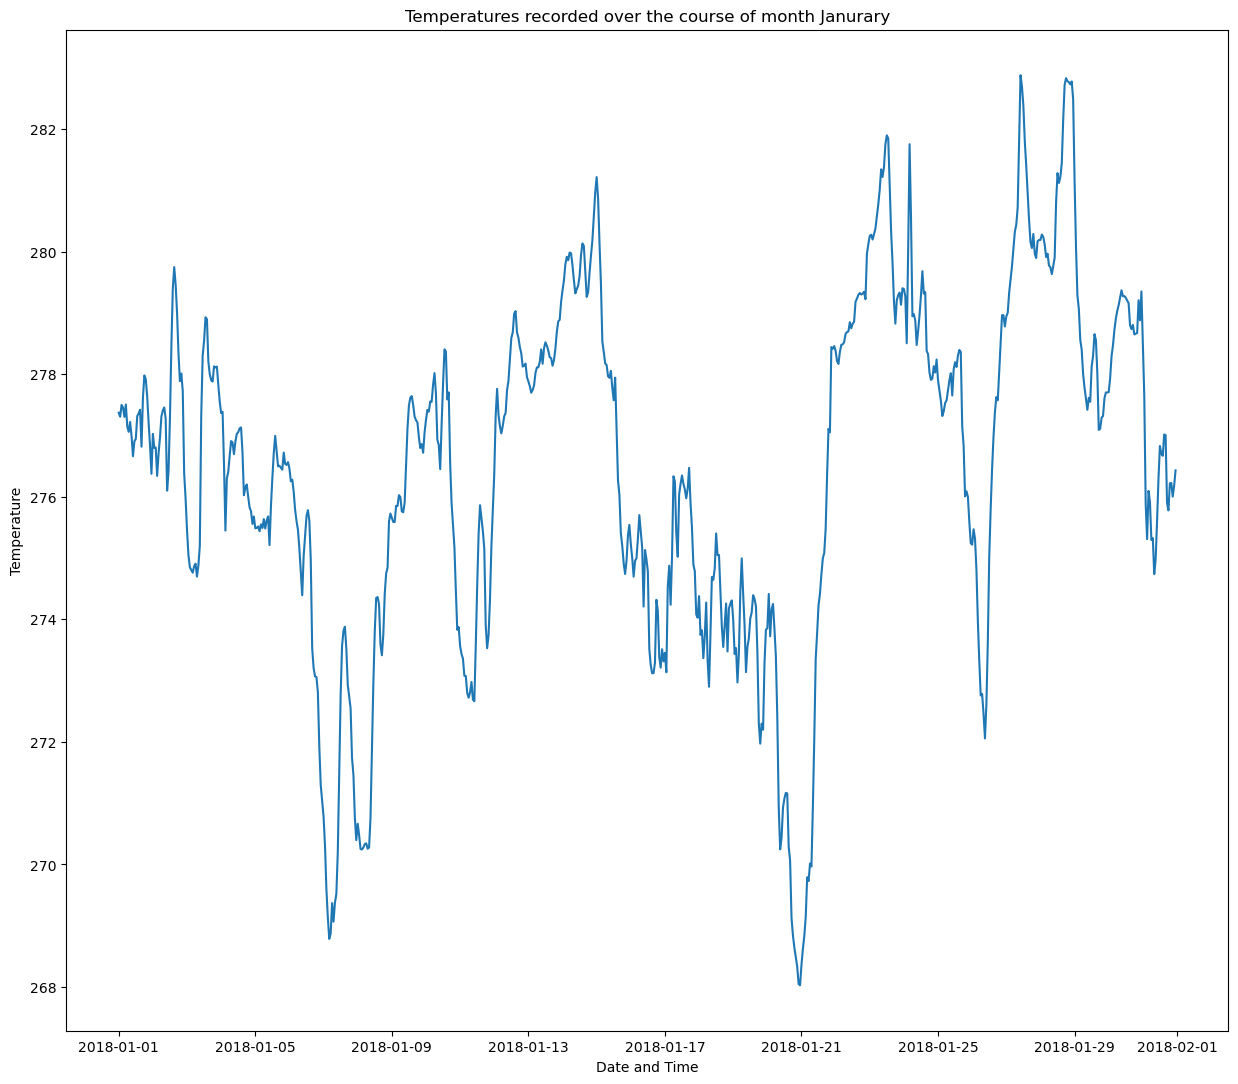

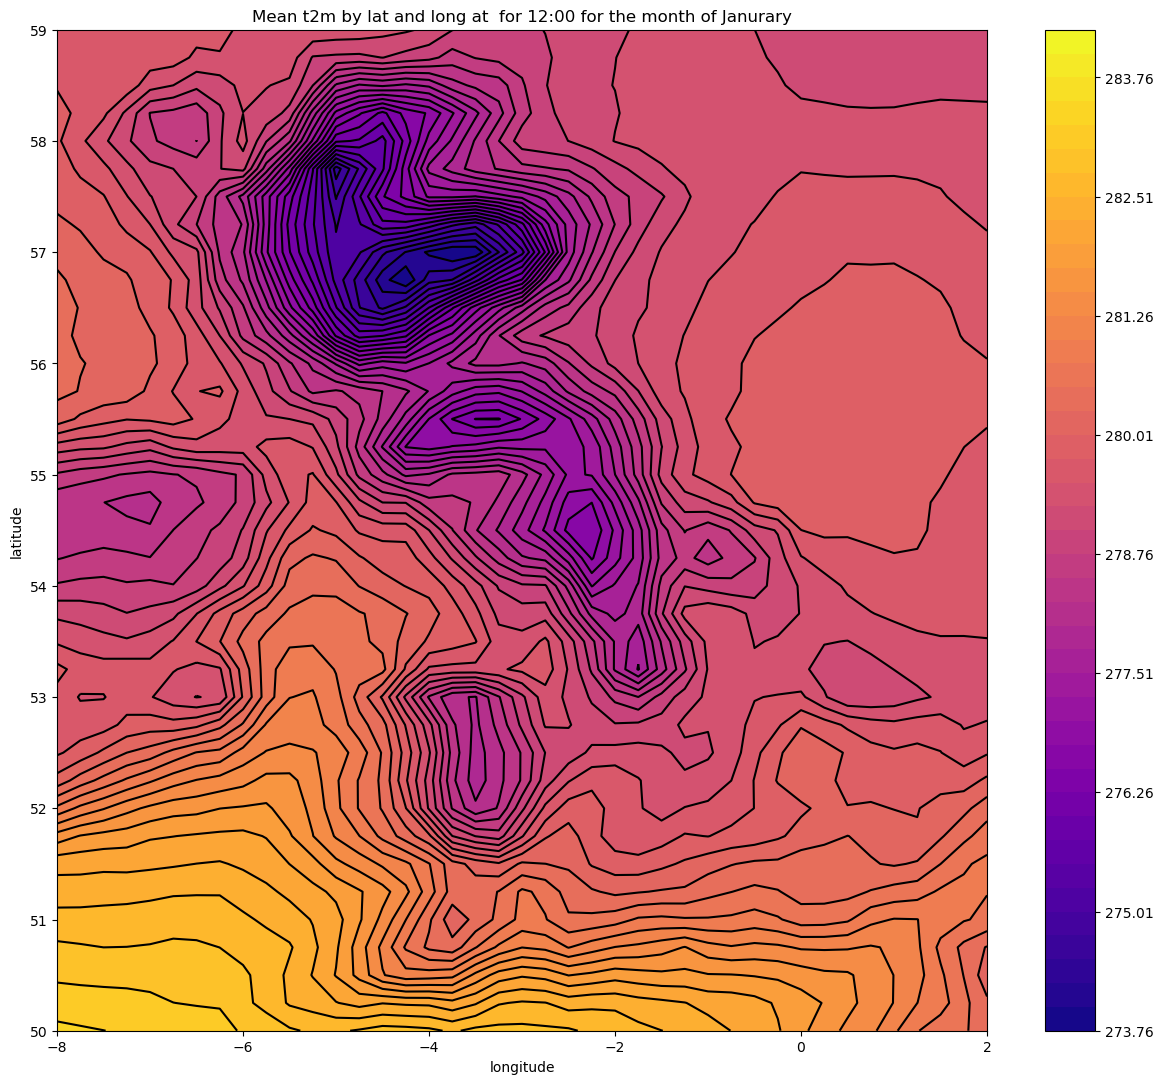

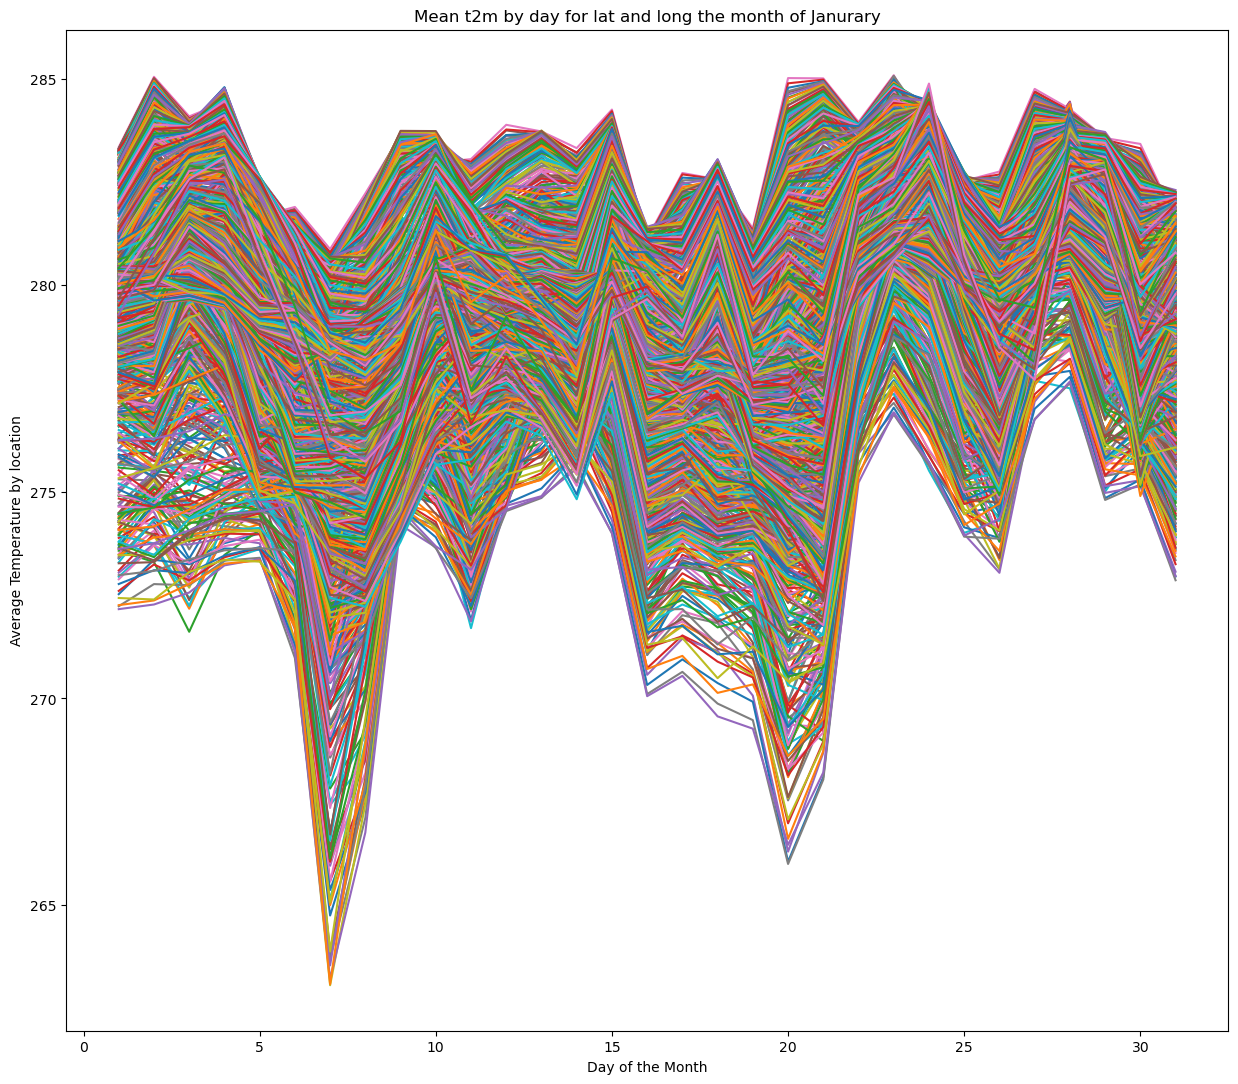

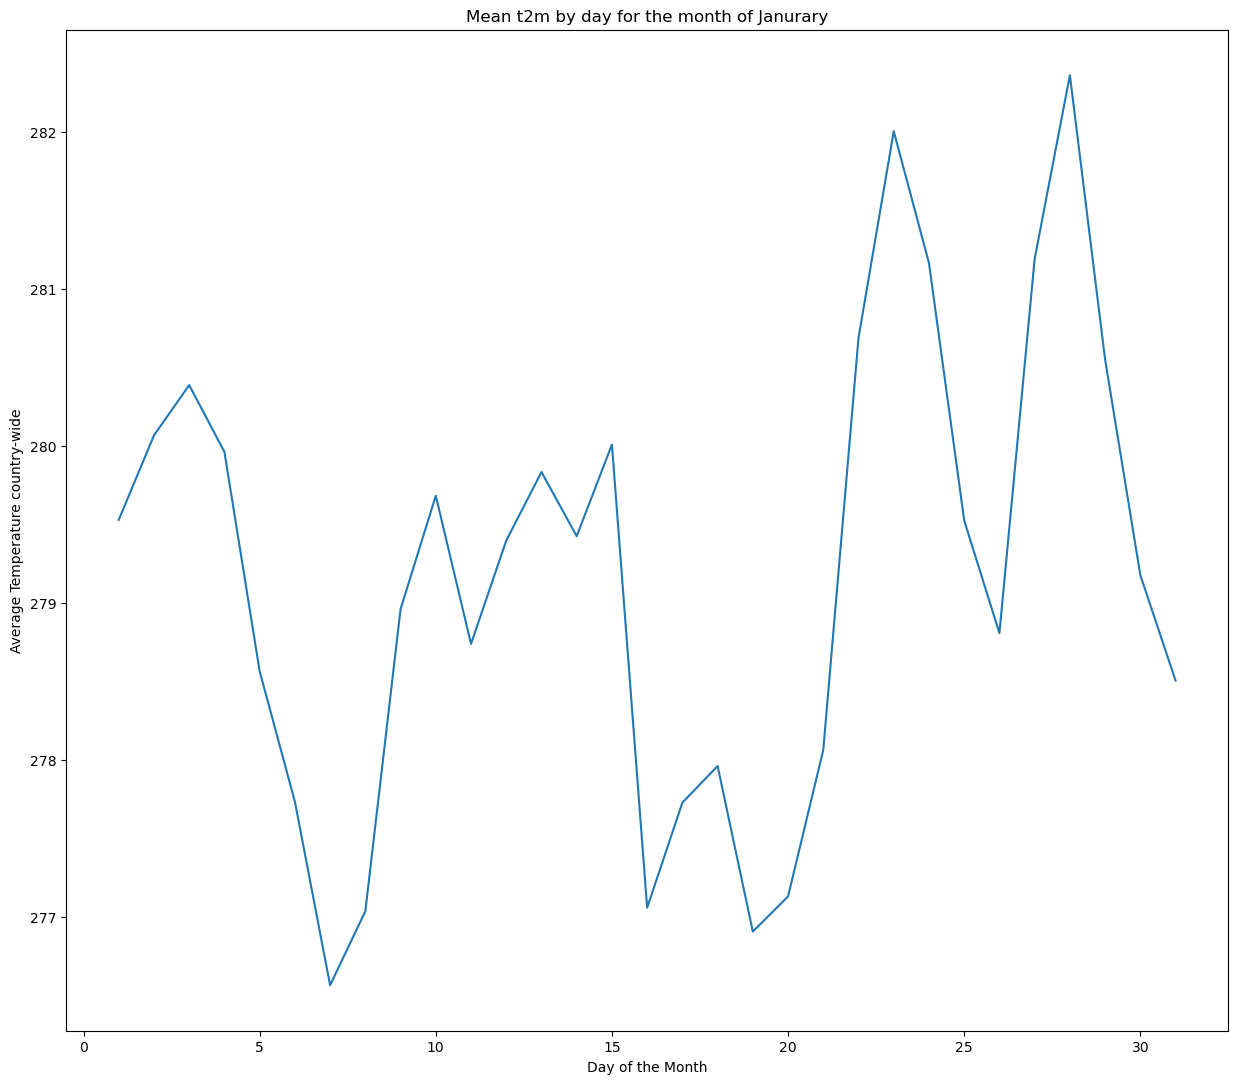

In [25]:
daily_temps(explore_df_jan, explore_df_jan["t2m"], explore_df_jan, "Janurary", 12)

# Data Wrangling

In [26]:
def split_times(data):
    data['valid_time'] = pd.to_datetime(data['valid_time'])
    data['hour'] = data['valid_time'].dt.hour
    data['month'] = data['valid_time'].dt.month
    data['day'] = data['valid_time'].dt.day
    return data

## Cyclical Time Feature Encoding  

Encoding Time Features as Cyclical Values  

Time-based features like hour, month, and dayofweek are cyclical, they repeat in a loop:  

Hour 23 is followed by hour 0 (midnight)  

Treating these as plain numbers would mislead the model into thinking that the highest values are "further away" from the lowest, when in fact they are neighbours.  

To handle this, we transform each feature using sine and cosine. This places the values on a circle, helping the model understand the cyclical nature of time.

In [27]:
def encode_time(data):
    # Encode 'hour' as cyclical
    data['hour_sin'] = np.sin(2 * np.pi * data['hour'] / 24)
    data['hour_cos'] = np.cos(2 * np.pi * data['hour'] / 24)

    # Encode 'month' as cyclical
    data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
    data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)
    return data

## Cyclical Wind Feature Encoding  

Encoding Wind Features as Cyclical Values  

Similar to the Time Feature encoding.  

December (12) is followed by January (1) 

Again, to handle this, we transform each feature using sine and cosine. This helps the model understand the cyclical nature of the months.

In [28]:
def encode_wind(data):
    # Wind direction (in degrees), where 0 = north, 90 = east, etc.
    data['wind10_dir'] = (np.arctan2(data['u10'], data['v10']) * (180 / np.pi)) % 360
    data['wind100_dir'] = (np.arctan2(data['u100'], data['v100']) * (180 / np.pi)) % 360

    # Convert to radians for sine/cosine encoding
    data['wind10_dir_rad'] = np.radians(data['wind10_dir'])

    # Sine and cosine components
    data['wind10_dir_sin'] = np.sin(data['wind10_dir_rad'])
    data['wind10_dir_cos'] = np.cos(data['wind10_dir_rad'])

    # Repeat for 100m wind in case it's useful
    data['wind100_dir_rad'] = np.radians(data['wind100_dir'])
    data['wind100_dir_sin'] = np.sin(data['wind100_dir_rad'])
    data['wind100_dir_cos'] = np.cos(data['wind100_dir_rad'])

    # Check the dataset
    data[['u10', 'v10', 'wind10_dir', 'wind10_dir_sin', 'wind10_dir_cos', 'wind100_dir']].sample(10)
    return data

In [29]:
def nearby_data(data, window = 3):
    features = ["wind100_dir_cos", "wind100_dir_sin", "wind10_dir_cos", "wind10_dir_sin"] # Need to change to be the correct features (dont know what the new wind ones will be called)
    for feature in features:
        data[feature + '_nearby'] = (
            data.groupby(['month', 'day', 'longitude', 'latitude'])[feature]
            .transform(lambda x: x.rolling(window=window, center=True, min_periods=1).mean())
        )
    return data.reset_index()

In [30]:
def redistribute_tp(data):
    data['tp_sqrt'] = np.sqrt(data['tp'])
    return data


In [31]:
def simplify_ptype(ptype):
    if ptype == 0:
        return 'none'
    elif ptype == 1:
        return 'rain'
    else:
        return 'other'


def encode_ptype(data):
    # Apply grouping
    data['ptype_grouped'] = data['ptype'].apply(simplify_ptype)
    return data

In [32]:
def split_month(data):
     # First let's create the half months cat
    month_section_vals = []
    dates = data["valid_time"].dt.day
    for day in dates:
        if day < 15:
            month_section_vals.append(1)
        else:
            month_section_vals.append(2)

    data["Month_half"] = month_section_vals
    return data

In [33]:
def pca_wind(data):
    #Now let's collapse the x_10 and x_100 data columns
    u_data_iso = data[["u10", "u100"]]
    pca_fit_pipe = PCA(n_components= 1)
    PCA_u_trans = pd.DataFrame(pca_fit_pipe.fit_transform(u_data_iso))
    v_data_iso = data[["v10", "v100"]]
    PCA_v_trans = pd.DataFrame(pca_fit_pipe.fit_transform(v_data_iso))


    #data = pd.concat([data, PCA_u_trans], axis = 1)    #Condensed u and v columns
    data["u_pca"] = PCA_u_trans
    data["v_pca"] = PCA_v_trans

    return data

In [34]:
def feature_selection(data):
    return data.drop(columns=['id', 'valid_time', 'day', 'ptype', 'tp', "u10", "v10", "v100", "u100", "index", "hour", "month", "wind10_dir_rad", "wind100_dir_rad"])

In [35]:
def data_wrangling_pipeline(data):
    data = split_times(data)
    data = split_month(data)
    data = encode_time(data)
    data = encode_wind(data)
    data = nearby_data(data)
    data = redistribute_tp(data)
    data = encode_ptype(data)
    data = pca_wind(data)
    data = feature_selection(data)
    return data

X_train = data_wrangling_pipeline(X_train)

# Modelling

In [36]:
X_train_sample = X_train.sample(n=1000, random_state=99) # Need to choose how much to take in the sample.....
y_train_sample = y_train.loc[X_train_sample.index]

X_train, X_valid, y_temps_train, y_temps_valid = train_test_split(X_train_sample, y_train_sample,
                                                                test_size=0.5, random_state= 99)

col_headers = X_train.columns.values

In [37]:
categorical_features = ["Month_half", "ptype_grouped"]
numerical_features =  ["latitude", "longitude", "tp_sqrt", "sp", "tcc", "u_pca", "v_pca", "hour_sin", "month_sin", "hour_cos", "month_cos","wind10_dir_sin", "wind10_dir_cos", "wind100_dir_sin", "wind100_dir_cos", "wind100_dir_cos_nearby", "wind100_dir_sin_nearby", "wind10_dir_cos_nearby", "wind10_dir_sin_nearby"]

data_pipeline = ColumnTransformer([
    ("Sd", StandardScaler(), numerical_features),
    ("1H", OneHotEncoder(sparse_output=False), categorical_features),
], remainder = "passthrough")

X_train_final = data_pipeline.fit_transform(X_train)
X_valid_final = data_pipeline.transform(X_valid)

In [38]:
def analyse(predictions, validation):
    mse = mean_squared_error(validation, predictions)
    mae = mean_absolute_error(validation, predictions)
    r2 = r2_score(validation, predictions)
    print("Random Forest Regressor on training data:")
    print(f"MSE: {mse:.3f}")
    print(f"MAE: {mae:.3f}")
    print(f"R2 Score: {r2:.3f}")

### Bagging Decision Tree

In [ ]:
bagging_temp_predictor = BaggingRegressor(
    DecisionTreeRegressor(random_state=99), n_estimators=50,
    max_samples=500, bootstrap=True, random_state=99, n_jobs = -2
)

bagging_temp_predictor.fit(X_train_final, y_temps_train)

BaggingRegressor(estimator=DecisionTreeRegressor(random_state=42),
                 max_samples=500, n_estimators=50, random_state=42)

In [ ]:
bag_predictions_valid = bagging_temp_predictor.predict(X_valid_final)

In [ ]:
bag_predictions_train = bagging_temp_predictor.predict(X_train_final)

In [ ]:
analyse(bag_predictions_valid, y_temps_valid)
analyse(bag_predictions_train, y_temps_valid)

Random Forest Regressor on training data:
MSE: 4.939
MAE: 1.676
R2 Score: 0.774
Random Forest Regressor on training data:
MSE: 44.918
MAE: 5.259
R2 Score: -1.052


### Random Forrest

In [ ]:
rf_temp_predictor = RandomForestRegressor(n_jobs=-2)
rf_temp_predictor.fit(X_train_final, y_temps_train)

RandomForestRegressor()

In [ ]:
rf_predictions_valid = rf_temp_predictor.predict(X_valid_final)

In [ ]:
rf_predictions_train = rf_temp_predictor.predict(X_train_final)

In [ ]:
analyse(rf_predictions_valid, y_temps_valid)
analyse(rf_predictions_train, y_temps_train)

Random Forest Regressor on training data:
MSE: 4.891
MAE: 1.655
R2 Score: 0.777
Random Forest Regressor on training data:
MSE: 0.968
MAE: 0.686
R2 Score: 0.960


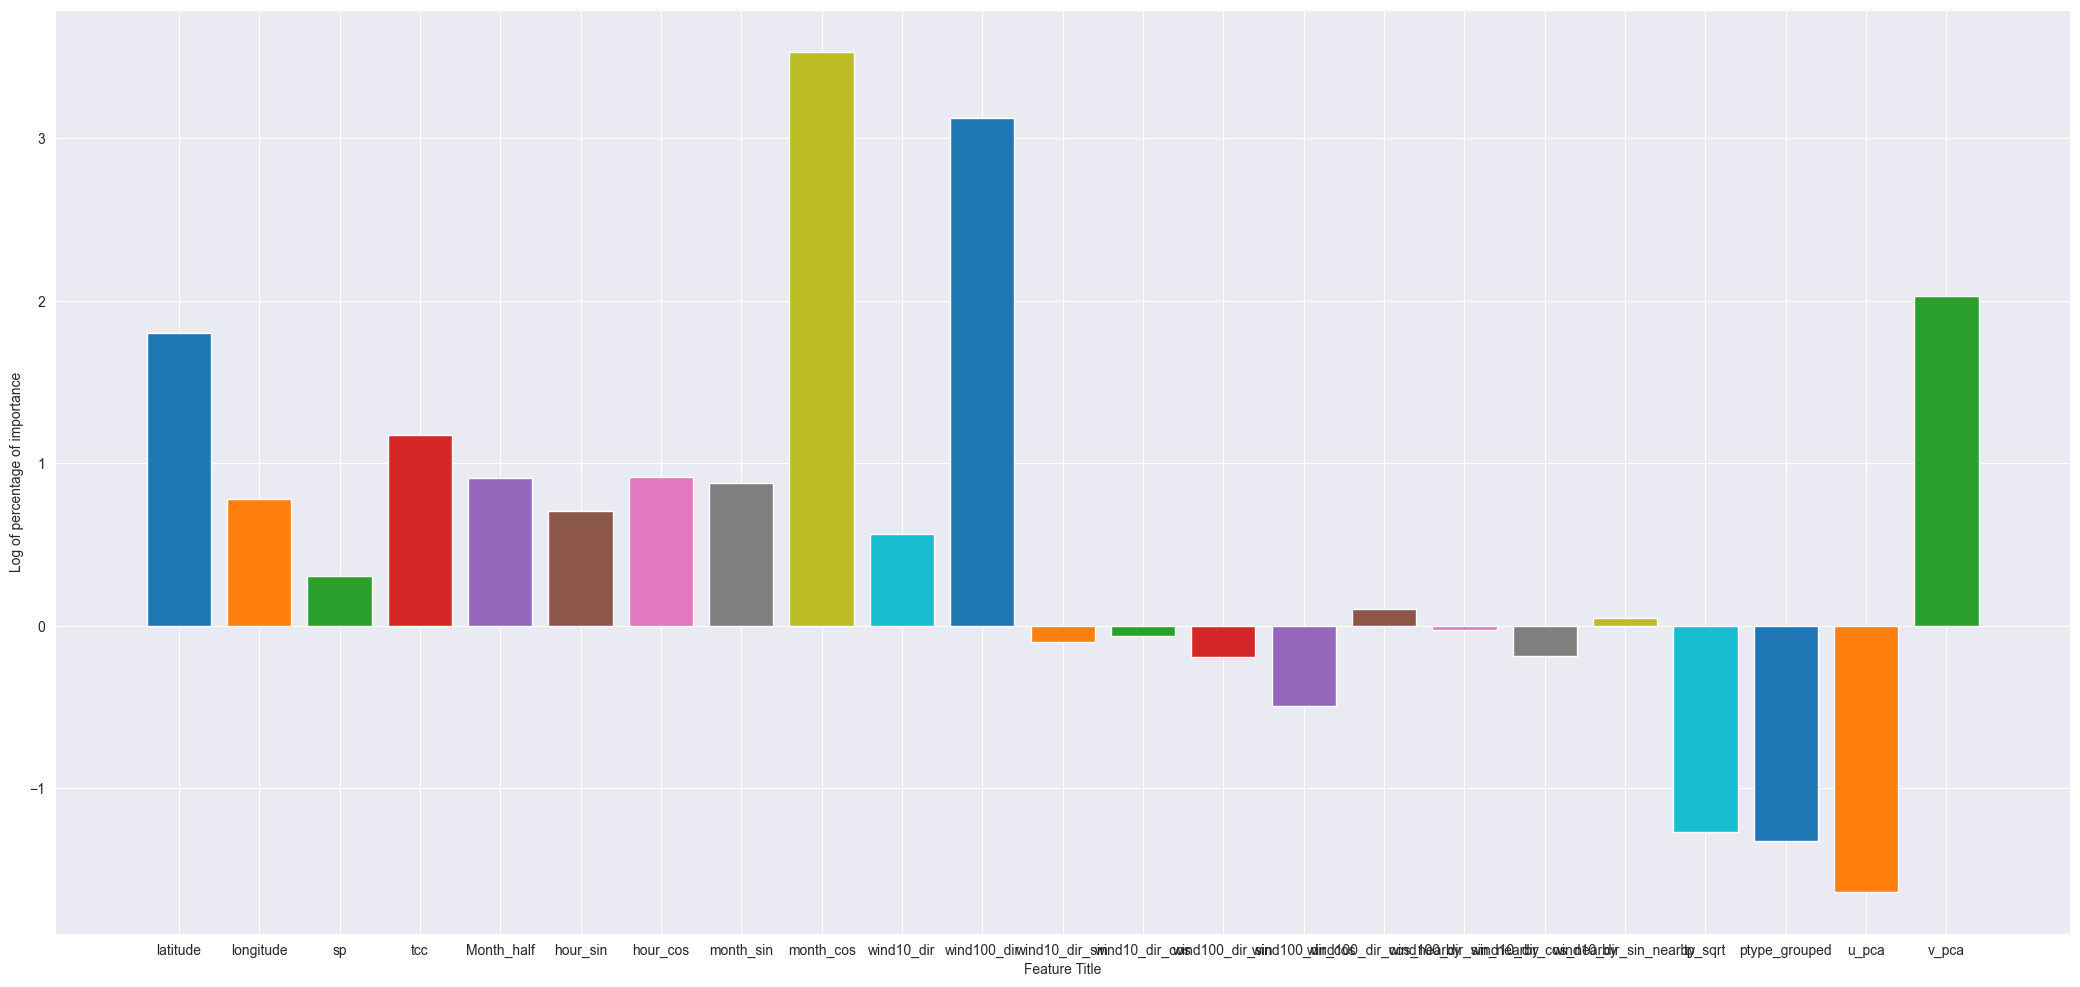

In [ ]:
def feature_importance(regressor):
    feature_names = list(col_headers)
    fig, ax7 = plt.subplots(figsize=(26, 12))

    for name, score in zip(feature_names, regressor.feature_importances_):
        ax7.bar(name, np.log(score*100))

    ax7.set_xlabel("Feature Title")
    ax7.set_ylabel("Log of percentage of importance")

feature_importance(rf_temp_predictor)

feature_names = list(X_train_final.columns.values)
fig, ax7 = plt.subplots(figsize=(26, 12))

for name, score in zip(feature_names, random_forest_weather_predictor.feature_importances_):
    ax7.bar(name, np.log(score*100))

ax7.set_xlabel("Feature Title")
ax7.set_ylabel("Log of percentage of importance")### Decision Tree

### Feed Forward Neural Net (Multi-Layer Perception)   

In [41]:
# Build a larger architecture model
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train_final.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

optimizer = Adam(learning_rate=0.001)

# Compile and train
model.compile(
    optimizer=optimizer,
    loss='mean_squared_error',
    metrics=['mean_absolute_error']
)

# Add early stopping
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Train model
history = model.fit(
    X_train_final, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - loss: 74718.8828 - mean_absolute_error: 271.7969 - val_loss: 41616.6875 - val_mean_absolute_error: 195.9349
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 39294.0078 - mean_absolute_error: 185.5438 - val_loss: 25811.9297 - val_mean_absolute_error: 136.2675
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 27487.5508 - mean_absolute_error: 144.9315 - val_loss: 26081.9297 - val_mean_absolute_error: 144.9283
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 27879.5898 - mean_absolute_error: 149.3806 - val_loss: 26479.1191 - val_mean_absolute_error: 146.3324
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 27386.7402 - mean_absolute_error: 148.2968 - val_loss: 24352.3301 - val_mean_absolute_error: 136.9405
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 26269.8340 - mean_absolute_error: 142.9149 - val_loss: 23988.1855 - val_mean_absolute_error: 134.3187
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/st

In [42]:
nn_predictions_valid = model.predict(X_valid_final)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [43]:
nn_predictions_train = model.predict(X_train_final)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [44]:
analyse(nn_predictions_valid, y_temps_valid)
analyse(nn_predictions_train, y_temps_train)

Random Forest Regressor on training data:
MSE: 2090.201
MAE: 26.525
R2 Score: -94.476
Random Forest Regressor on training data:
MSE: 1079.206
MAE: 24.234
R2 Score: -43.311


## Results after fine tuning  

These are the results of the Feed Forward Neural Network before and after fine tuning 

Before tuning: RMSE = 1.92 and MAE = 1.44  
Adjusting the Architecture: RSME = 1.81 and MAE = 1.34  
Reduction of epochs (50) and patience (3) and changing the learning rate (0.001): RMSE = 1.82 and MAE = 1.35  

The best result based on a small section of the data is making the achitecture larger than it was originally.

## Decision Tree

In [ ]:
dt_temp_predictor = DecisionTreeRegressor(max_depth=5, random_state=42)
dt_temp_predictor.fit(X_train_final, y_temps_train)

DecisionTreeRegressor(max_depth=5, random_state=42)

In [ ]:
dt_predictions_valid = dt_temp_predictor.predict(X_valid_final)

In [ ]:
dt_predictions_train = dt_temp_predictor.predict(X_train_final)

In [ ]:
analyse(dt_predictions_valid, y_temps_valid)
analyse(dt_predictions_train, y_temps_train)

Random Forest Regressor on training data:
MSE: 7.086
MAE: 1.971
R2 Score: 0.676
Random Forest Regressor on training data:
MSE: 5.205
MAE: 1.686
R2 Score: 0.786


/var/folders/7x/9t6kbk7527155j9m2f98pg040000gn/T/ipykernel_36100/3901176682.py:6: RuntimeWarning: divide by zero encountered in log
  ax7.bar(name, np.log(score*100))


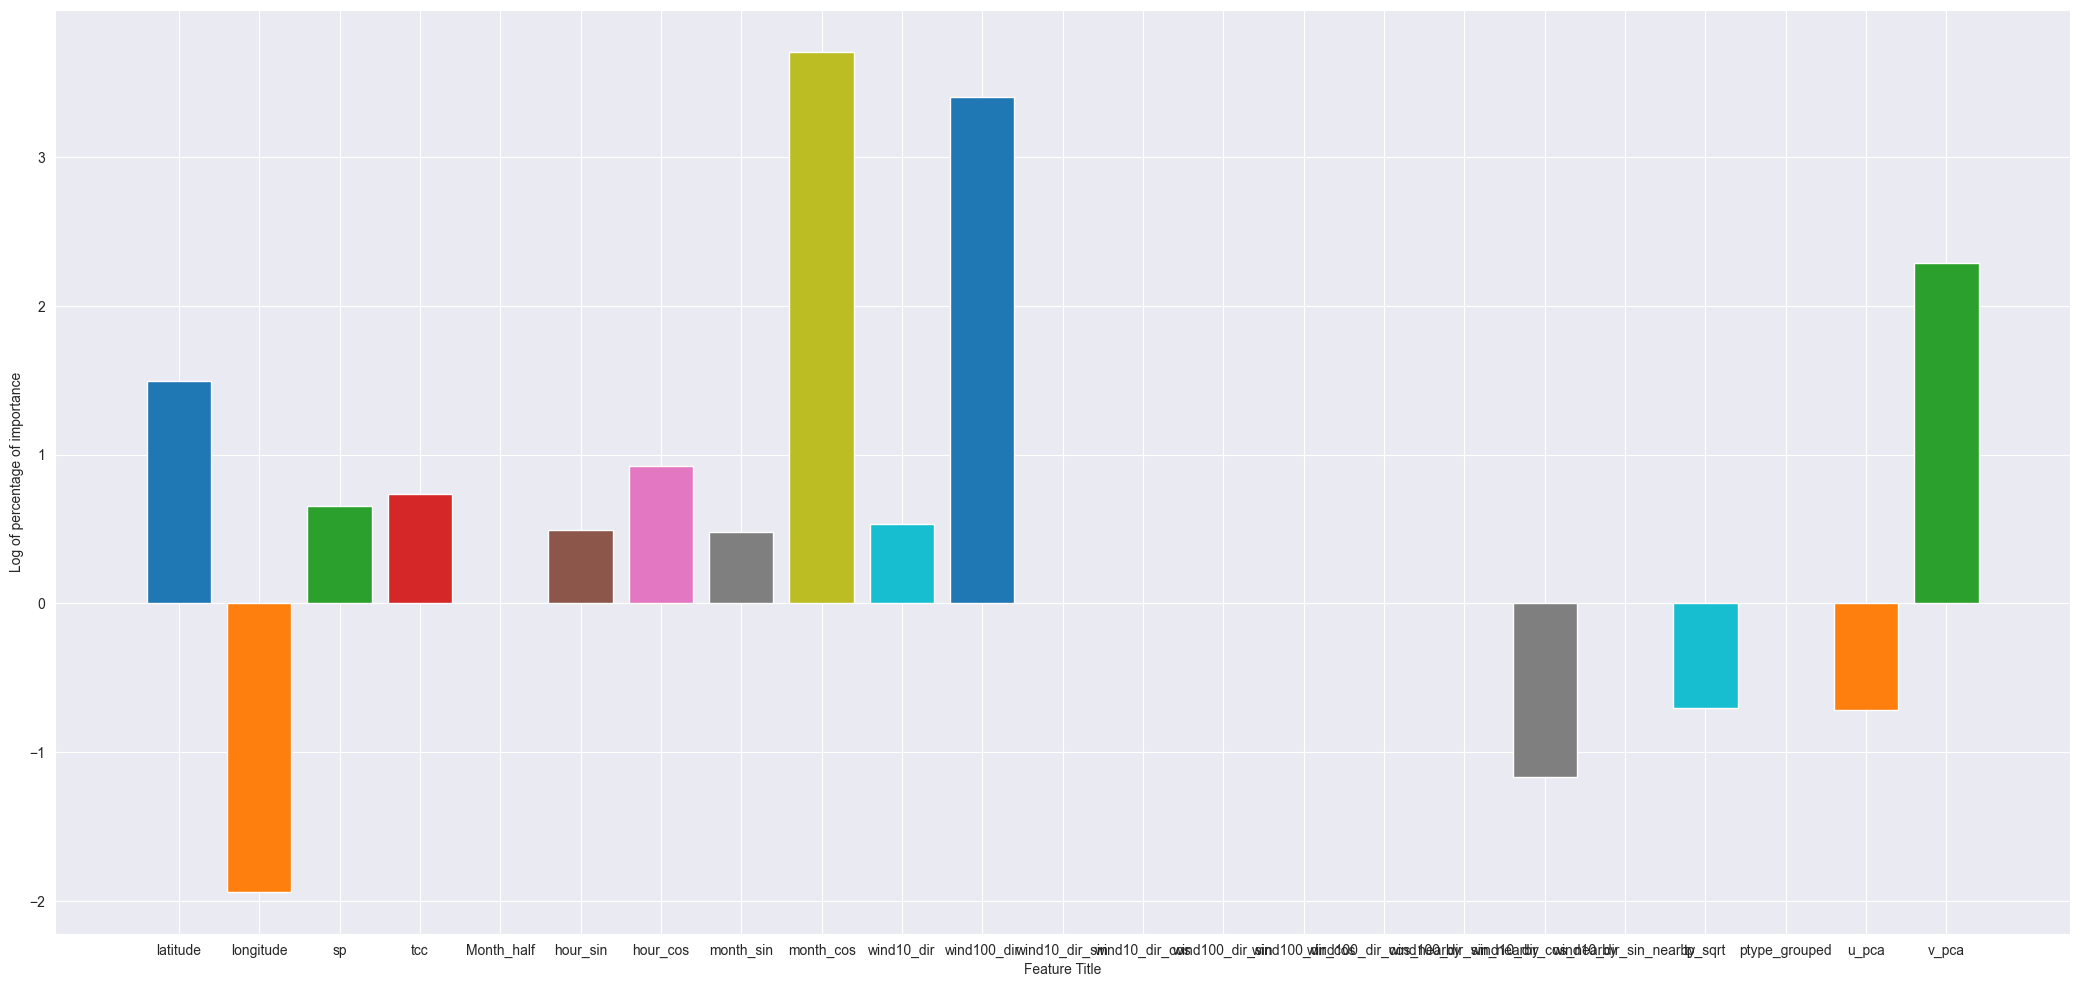

In [ ]:
feature_importance(dt_temp_predictor)